# StarDist Model Training

This notebook trains the StarDist model for object detection and segmentation.

**Key Steps:**
1. **Data Preparation**: Loads and normalizes training images and masks.
2. **Configuration**: Sets up StarDist2D parameters (Grid, Rays, Epochs).
3. **Augmentation**: Applies random flips, rotations, and intensity changes.
4. **Training**: Trains the StarDist model with validation splitting.
5. **Evaluation**: Optimizes thresholds and plots matching statistics.

**Input**: `data-v2`
**Output**: `Models`

In [ ]:
# RAW_DATA_FOLDER = '/kaggle/input/annotationstardist'
# MODEL_FOLDER = '/kaggle/working/models'
# image_folder = os.path.join(RAW_DATA_FOLDER, 'AnnotationStardistTif', 'images')
# mask_folder = os.path.join(RAW_DATA_FOLDER, 'AnnotationStardistTif', 'masks')

# # Đọc các đường dẫn tới các tệp ảnh và mặt nạ
# image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
# mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))
# print(image_files)


In [ ]:
from stardist.matching import matching_dataset
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os

class MatchingEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, sd_model, X_val, Y_val, out_dir,
                 taus=None, eval_every=10):
        super().__init__()
        self.model_sd = sd_model           # StarDist2D object
        self.X_val = X_val
        self.Y_val = Y_val
        self.out_dir = out_dir
        self.eval_every = eval_every
        self.taus = taus or [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        os.makedirs(out_dir, exist_ok=True)

    def _predict_val(self):
        preds = []
        for x in self.X_val:
            lbl, _ = self.model_sd.predict_instances(
                x, n_tiles=self.model_sd._guess_n_tiles(x),
                show_tile_progress=False
            )
            preds.append(lbl)
        return preds

    def _plot_stats(self, stats, epoch):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        metrics = ('precision','recall','accuracy','f1',
                   'mean_true_score','mean_matched_score','panoptic_quality')
        for m in metrics:
            ax1.plot(self.taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
        ax1.set_xlabel(r'IoU threshold $\tau$'); ax1.set_ylabel('Metric value')
        ax1.grid(True, alpha=0.3); ax1.legend()

        for m in ('fp','tp','fn'):
            ax2.plot(self.taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
        ax2.set_xlabel(r'IoU threshold $\tau$'); ax2.set_ylabel('Number #')
        ax2.grid(True, alpha=0.3); ax2.legend()

        fname = os.path.join(self.out_dir, f"matching_epoch{epoch:03d}.png")
        plt.tight_layout(); plt.savefig(fname); plt.close()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.eval_every:
            return
        Y_pred = self._predict_val()
        stats = [
            matching_dataset(self.Y_val, Y_pred, thresh=t, show_progress=False)
            for t in self.taus
        ]
        if logs is not None:
            logs['matching_acc_tau_0.5'] = stats[self.taus.index(0.5)].accuracy
        self._plot_stats(stats, epoch + 1)

2025-11-19 05:31:03.129707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763530263.351275      97 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763530263.414904      97 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100%|██████████| 50/50 [00:00<00:00, 95.69it/s] 


number of images:  50
training:        42
validation:       8


I0000 00:00:1763530278.948660      97 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763530278.949573      97 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/20


I0000 00:00:1763530291.619114     153 service.cc:148] XLA service 0x7b8684001f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763530291.619936     153 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763530291.619969     153 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763530293.066575     153 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763530303.603491     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - dist_dist_iou_metric: 0.6684 - dist_loss: 2.6707 - dist_relevant_mae: 2.6704 - dist_relevant_mse: 23.8371 - loss: 0.7030 - prob_kld: 0.0390 - prob_loss: 0.1689 - val_dist_dist_iou_metric: 0.7209 - val_dist_loss: 2.1933 - val_dist_relevant_mae: 2.1930 - val_dist_relevant_mse: 16.3387 - val_loss: 0.5876 - val_prob_kld: 0.0268 - val_prob_loss: 0.1489 - learning_rate: 3.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dist_dist_iou_metric: 0.6904 - dist_loss: 2.4304 - dist_relevant_mae: 2.4300 - dist_relevant_mse: 20.0099 - loss: 0.6456 - prob_kld: 0.0303 - prob_loss: 0.1596 - val_dist_dist_iou_metric: 0.7333 - val_dist_loss: 2.1550 - val_dist_relevant_mae: 2.1547 - val_dist_relevant_mse: 15.7953 - val_loss: 0.5793 - val_prob_kld: 0.0262 - val_prob_loss: 0.1483 - learning_rate: 3.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dist_dist_iou_metric: 0.6979 - dist_loss: 2.3832 - dist_relevant_mae: 2.3829 - dist_rele

functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 512, 1024, 1))
functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 1))
NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:02,  7.60it/s, 0.837 -> 0.000]


Using optimized values: prob_thresh=0.418312, nms_thresh=0.3.
Saving to 'thresholds.json'.


Matching stats: 100%|██████████| 7/7 [00:00<00:00, 12.02it/s]


Debug stats:
Tau=0.01: precision=0.0125, recall=1.0000, tp=8, fp=631
Tau=0.05: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.1: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.2: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.3: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.4: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.5: precision=0.0000, recall=0.0000, tp=0, fp=639
  _asdict() available: {'criterion': 'iou', 'thresh': 0.5, 'fp': 639, 'tp': 0, 'fn': 8, 'precision': 0, 'recall': 0, 'accuracy': 0, 'f1': 0, 'n_true': 8, 'n_pred': 639, 'mean_true_score': 0.0, 'mean_matched_score': 0.0, 'panoptic_quality': 0.0, 'by_image': False}


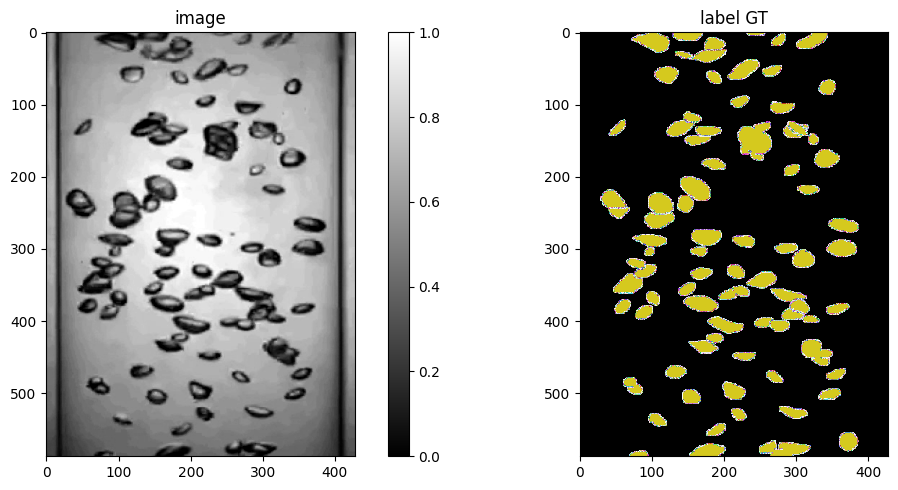

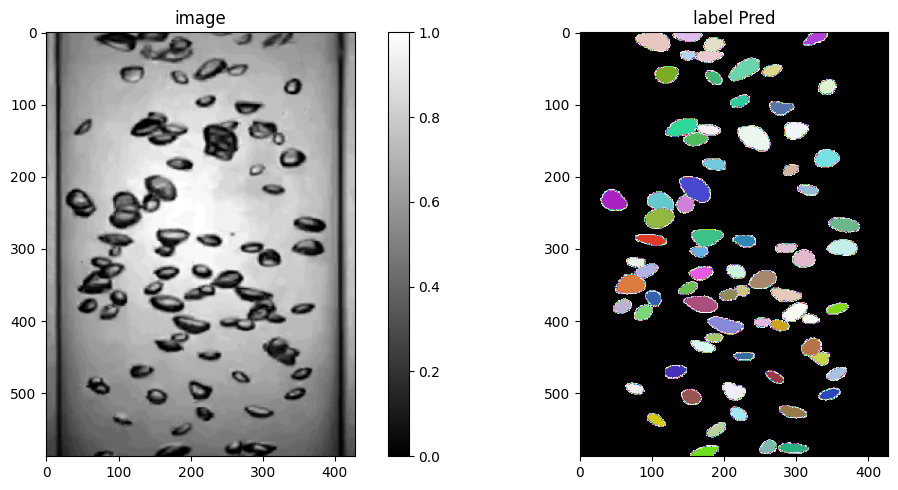

In [3]:
#train từ origin
import numpy as np
import matplotlib.pyplot as plt
from stardist import fill_label_holes, gputools_available, random_label_cmap
from stardist.models import StarDist2D, Config2D
from stardist.matching import matching_dataset
from tifffile import imread
import os
from csbdeep.utils import normalize
from glob import glob
from tqdm import tqdm
import json
lbl_cmap = random_label_cmap()

#train từ model origin
from stardist.models import StarDist2D
from skimage.io import imread


RAW_DATA_FOLDER = '/kaggle/input'
MODEL_FOLDER = '/kaggle/working/models'

# Common variables
EPOCHS = 10  # Số epoch huấn luyện
# USE_GPU = gputools_available()
RAYS = 64  # Số lượng tia phát ra từ tâm
GRID = (4, 8)  # Kích thước grid
N_CHANNEL = 1

def training(datarawName, epochs, rays):

    if epochs:
        EPOCHS = int(epochs)
    if rays:
        RAYS = int(rays)

    modelName = datarawName + '_' + rays + '_' + epochs

    # Đường dẫn tới các thư mục chứa ảnh và mặt nạ
    image_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'origin_tif')
    mask_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'mask_tif')
    print()

    # Đọc các đường dẫn tới các tệp ảnh và mặt nạ
    image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
    mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

    # Kiểm tra số lượng tệp ảnh và mặt nạ
    assert len(image_files) == len(mask_files), "Số lượng ảnh và mặt nạ không khớp"

    # Đọc dữ liệu
    X = list(map(imread, image_files))
    Y = list(map(imread, mask_files))

    # Kiểm tra kích thước của các ảnh và mặt nạ
    for x, y in zip(X, Y):
        assert x.shape == y.shape, "Ảnh và mặt nạ phải có cùng kích thước"

    # Trục cần được chuẩn hóa độc lập (theo chiều không gian: trục 0 và 1)
    axis_norm = (0, 1)

    # Chuẩn hóa dữ liệu đầu vào (X) bằng cách scale pixel theo các percentiles 1% và 99.8%
    X = [normalize(x, 1, 99.8, axis=axis_norm) for x in X]
    # Điền lỗ hổng (fill holes) trong nhãn (Y) để đảm bảo nhãn không bị gián đoạn
    Y = [fill_label_holes(y) for y in tqdm(Y)]

    # Kiểm tra số lượng dữ liệu, phải có ít nhất 2 mẫu trở lên
    assert len(X) > 1, "not enough training data"

    rng = np.random.RandomState(42)
    # Hoán vị chỉ số của toàn bộ dữ liệu
    ind = rng.permutation(len(X))

    # Chia dữ liệu thành tập train và validation, tỷ lệ validation là 15%
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_train, ind_val = ind[:-n_val], ind[-n_val:]

    # Lấy dữ liệu train và validation theo các chỉ số
    X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
    X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

    # In số lượng ảnh, số ảnh dùng để train và số ảnh dùng để validation
    print('number of images: %3d' % len(X))
    print('training:       %3d' % len(X_trn))
    print('validation:     %3d' % len(X_val))

    # # Giới hạn bộ nhớ GPU nếu sử dụng GPU để tránh xung đột tài nguyên
    # if USE_GPU:
    #     from csbdeep.utils.tf import limit_gpu_memory
    #     limit_gpu_memory(0.8)  # Giới hạn GPU sử dụng tối đa 80% bộ nhớ

    config_path = "/kaggle/input/stardist-model-origin/stardist/config.json"
    
    with open(config_path) as f:
        cfg_dict = json.load(f)
    
    cfg = Config2D(**cfg_dict)
    cfg.use_gpu = False        # tắt gputools
    cfg.train_patch_size = (256, 256)

    
    model = StarDist2D(
        config=cfg,
        name=modelName,
        basedir="/kaggle/working"
    )
    model.load_weights("/kaggle/input/stardist-model-origin/stardist/weights_last.h5") 
    


    # Huấn luyện mô hình với dữ liệu train và validation, đồng thời sử dụng augmenter
    history = model.train(X_trn, Y_trn, epochs=EPOCHS, validation_data=(X_val, Y_val), augmenter=augmenter)
    # Tối ưu hóa ngưỡng phân đoạn (thresholds) dựa trên tập validation
    model.optimize_thresholds(X_val, Y_val)

    # Lưu log training history
    # save_log_training(history, modelName)

    # Vẽ biểu đồ
    # loss_during_training(history, modelName)
    Y_val_pred = [model.predict_instances(x,n_tiles=model._guess_n_tiles(x),show_tile_progress=False)[0] for x in tqdm(X_val, desc="Predict val")    ]
    plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
    plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

    # taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    taus = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    stats = [
       matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus, desc="Matching stats")
    ]
    print("Debug stats:")
    for i, tau in enumerate(taus):
        s = stats[i]
        print(f"Tau={tau}: precision={s.precision:.4f}, recall={s.recall:.4f}, tp={s.tp}, fp={s.fp}")
    if hasattr(s, '_asdict'):
        print(f"  _asdict() available: {s._asdict()}")
    else:
        print("  _asdict() NOT available - using direct attribute access")

    out_dir = os.path.join(MODEL_FOLDER, modelName, "metrics")
    os.makedirs(out_dir, exist_ok=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    for m in ('precision','recall','accuracy','f1',
              'mean_true_score','mean_matched_score','panoptic_quality'):
        ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$'); ax1.set_ylabel('Metric value')
    ax1.grid(True, alpha=0.3); ax1.legend()
    
    for m in ('fp','tp','fn'):
        ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$'); ax2.set_ylabel('Number #')
    ax2.grid(True, alpha=0.3); ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "matching_tau_curve.png"))
    plt.close()
    return model
    
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

# Lưu log training
def save_log_training(history, modelName):
    history_file = os.path.join(MODEL_FOLDER, modelName, "training_history.json")
    with open(history_file, 'w') as f:
        json.dump(history.history, f)
    print(f"Training history saved at {history_file}")


# Vẽ biểu đồ loss
def loss_during_training(history, modelName):
    # Đảm bảo thư mục tồn tại
    os.makedirs(MODEL_FOLDER, exist_ok=True)

    # Đường dẫn đầy đủ đến file
    filepath = os.path.join(MODEL_FOLDER, modelName, 'loss_plot.png')

    # Lấy các giá trị loss từ history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Áp dụng hàm sigmoid vào các giá trị loss
    train_loss_sigmoid = sigmoid(np.array(train_loss))
    val_loss_sigmoid = sigmoid(np.array(val_loss))

    # Tạo dãy số lượng epoch
    epochs_range = range(1, len(train_loss) + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_loss_sigmoid, label='Training Loss (Sigmoid)', marker='o')
    plt.plot(epochs_range, val_loss_sigmoid, label='Validation Loss (Sigmoid)', marker='o')
    plt.title('Loss During Training (Sigmoid)')
    plt.xlabel('Epoch')
    plt.ylabel('Sigmoid Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Lưu biểu đồ
    plt.savefig(filepath)
    plt.close()  # Đóng biểu đồ để tránh lỗi bộ nhớ

    print(f"Biểu đồ đã được lưu tại: {filepath}")

# Vẽ biểu đồ IOU
def iou_during_training(history, modelName):
    # Đảm bảo thư mục tồn tại
    os.makedirs(MODEL_FOLDER, exist_ok=True)

    # Đường dẫn lưu biểu đồ
    filepath = os.path.join(MODEL_FOLDER, modelName, 'iou_plot.png')

    # Lấy giá trị IOU từ history (giả sử có 'iou' và 'val_iou' trong history)
    train_iou = history.history.get('iou', [])
    val_iou = history.history.get('val_iou', [])

    if not train_iou or not val_iou:
        print("No IOU data found in history.")
        return

    # Dãy số lượng epoch
    epochs_range = range(1, len(train_iou) + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_iou, label='Training IOU', marker='o')
    plt.plot(epochs_range, val_iou, label='Validation IOU', marker='o')
    plt.title('IOU During Training')
    plt.xlabel('Epoch')
    plt.ylabel('IOU')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Lưu biểu đồ
    plt.savefig(filepath)
    plt.close()

    print(f"Biểu đồ IOU đã được lưu tại: {filepath}")

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img * np.random.uniform(0.6, 2) + np.random.uniform(-0.2, 0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Áp dụng phép lật và xoay ngẫu nhiên cho ảnh và nhãn
    x, y = random_fliprot(x, y)

    # Thay đổi cường độ ảnh một cách ngẫu nhiên (tăng/giảm độ sáng)
    x = random_intensity_change(x)

    # Thêm một chút nhiễu Gaussian vào ảnh để tăng độ phong phú cho dữ liệu
    sig = 0.02 * np.random.uniform(0, 1)    # Tạo giá trị sigma ngẫu nhiên từ 0 đến 0.02
    x = x + sig * np.random.normal(0, 1, x.shape)   # Thêm nhiễu Gaussian vào ảnh

    # Trả về ảnh đã được tăng cường (augmented) cùng với nhãn gốc
    return x, y

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model = training(datarawName='data-v2', epochs='20', rays='64')

/kaggle/input/data-v2/origin_tif
number of images ok:  50


100%|██████████| 50/50 [00:00<00:00, 104.67it/s]


number of images:  50
training:        42
validation:       8


Matching stats: 100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


Debug stats:
Tau=0.1: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.2: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.3: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.4: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.5: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.6: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.7: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.8: precision=0.0000, recall=0.0000, tp=0, fp=639
Tau=0.9: precision=0.0000, recall=0.0000, tp=0, fp=639
  _asdict() available: {'criterion': 'iou', 'thresh': 0.9, 'fp': 639, 'tp': 0, 'fn': 8, 'precision': 0, 'recall': 0, 'accuracy': 0, 'f1': 0, 'n_true': 8, 'n_pred': 639, 'mean_true_score': 0.0, 'mean_matched_score': 0.0, 'panoptic_quality': 0.0, 'by_image': False}


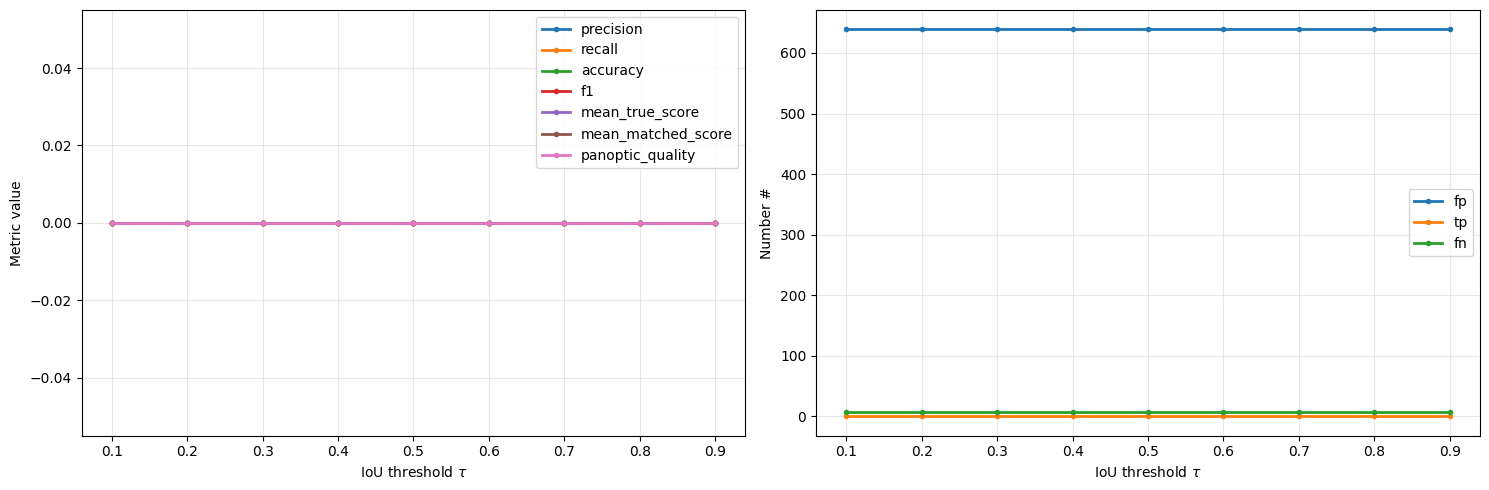

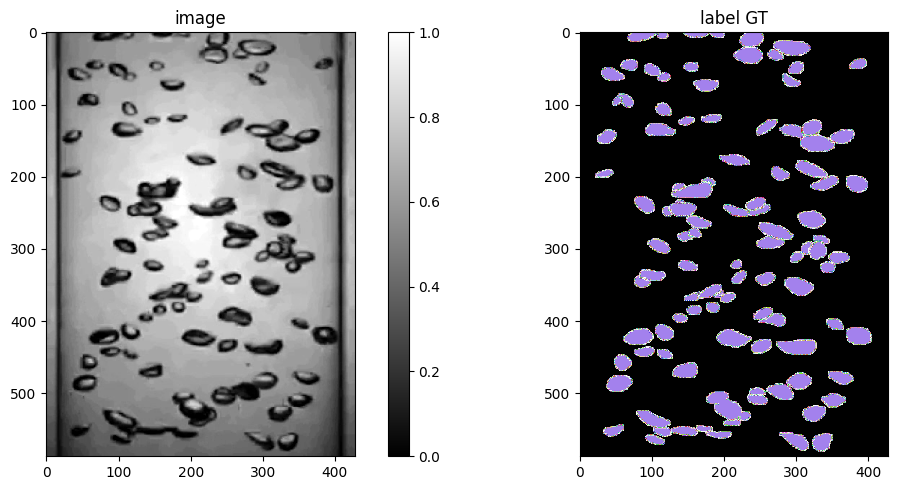

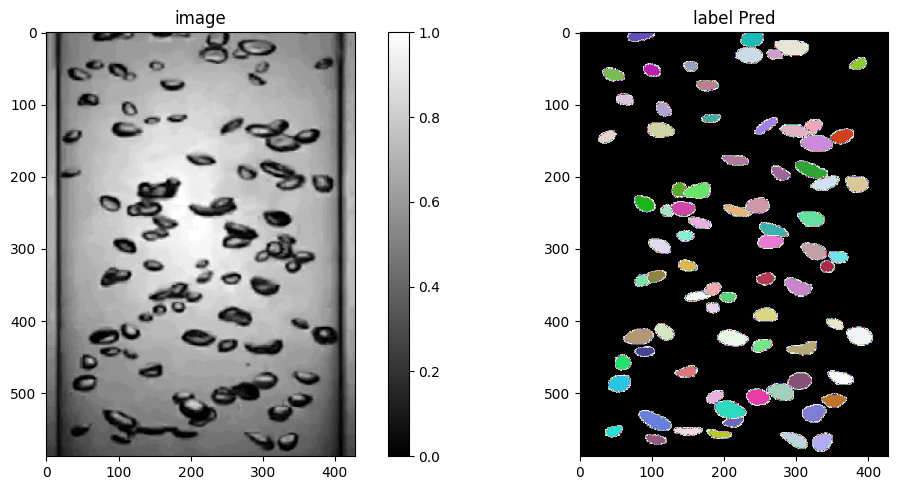

In [12]:
# evaluate
from stardist.matching import matching_dataset
from tqdm import tqdm
import os
from stardist.matching import matching_dataset
from tifffile import imread
from csbdeep.utils import normalize
from glob import glob
import json
from stardist import fill_label_holes, gputools_available, random_label_cmap
from stardist.models import StarDist2D, Config2D
from stardist.matching import matching_dataset
from tifffile import imread
import os
from csbdeep.utils import normalize

lbl_cmap = random_label_cmap()

RAW_DATA_FOLDER = '/kaggle/input'
MODEL_FOLDER = '/kaggle/working/models'
datarawName = '/data_v2'
# Đường dẫn tới các thư mục chứa ảnh và mặt nạ
image_folder = os.path.join(RAW_DATA_FOLDER, 'data-v2', 'origin_tif')
mask_folder = os.path.join(RAW_DATA_FOLDER, 'data-v2', 'mask_tif')
print(image_folder)
# Đọc các đường dẫn tới các tệp ảnh và mặt nạ
image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

# Kiểm tra số lượng tệp ảnh và mặt nạ
assert len(image_files) == len(mask_files), "Số lượng ảnh và mặt nạ không khớp"

# Đọc dữ liệu
X = list(map(imread, image_files))
Y = list(map(imread, mask_files))
print('number of images ok: %3d' % len(X))

# Kiểm tra kích thước của các ảnh và mặt nạ
for x, y in zip(X, Y):
    assert x.shape == y.shape, "Ảnh và mặt nạ phải có cùng kích thước"

# Trục cần được chuẩn hóa độc lập (theo chiều không gian: trục 0 và 1)
axis_norm = (0, 1)

# Chuẩn hóa dữ liệu đầu vào (X) bằng cách scale pixel theo các percentiles 1% và 99.8%
X = [normalize(x, 1, 99.8, axis=axis_norm) for x in X]
# Điền lỗ hổng (fill holes) trong nhãn (Y) để đảm bảo nhãn không bị gián đoạn
Y = [fill_label_holes(y) for y in tqdm(Y)]

# Kiểm tra số lượng dữ liệu, phải có ít nhất 2 mẫu trở lên
assert len(X) > 1, "not enough training data"

rng = np.random.RandomState(42)
# Hoán vị chỉ số của toàn bộ dữ liệu
ind = rng.permutation(len(X))

# Chia dữ liệu thành tập train và validation, tỷ lệ validation là 15%
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

# Lấy dữ liệu train và validation theo các chỉ số
X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

# In số lượng ảnh, số ảnh dùng để train và số ảnh dùng để validation
print('number of images: %3d' % len(X))
print('training:       %3d' % len(X_trn))
print('validation:     %3d' % len(X_val))

Y_val_pred = [
    model.predict_instances(
       x,
       n_tiles=model._guess_n_tiles(x),
       show_tile_progress=False
    )[0]
    for x in tqdm(X_val, desc="Predict val")
]

taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
stats = [
   matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False)
   for t in tqdm(taus, desc="Matching stats")
]
print("Debug stats:")
for i, tau in enumerate(taus):
    s = stats[i]
    print(f"Tau={tau}: precision={s.precision:.4f}, recall={s.recall:.4f}, tp={s.tp}, fp={s.fp}")
if hasattr(s, '_asdict'):
    print(f"  _asdict() available: {s._asdict()}")
else:
    print("  _asdict() NOT available - using direct attribute access")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for m in ('precision','recall','accuracy','f1',
          'mean_true_score','mean_matched_score','panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$'); ax1.set_ylabel('Metric value')
ax1.grid(True, alpha=0.3); ax1.legend()

for m in ('fp','tp','fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$'); ax2.set_ylabel('Number #')
ax2.grid(True, alpha=0.3); ax2.legend()

plt.tight_layout()
plt.show()
plt.close()
plot_img_label(X_val[7],Y_val[7], lbl_title="label GT")
plot_img_label(X_val[7],Y_val_pred[7], lbl_title="label Pred")



In [ ]:
import numpy as np
from tifffile import imread
import os
from csbdeep.utils import normalize
from glob import glob
from tqdm import tqdm
import json
from stardist import fill_label_holes, gputools_available

RAW_DATA_FOLDER = '/kaggle/input/stardist'

# Đường dẫn tới các thư mục chứa ảnh và mặt nạ
image_folder = os.path.join(RAW_DATA_FOLDER, 'data', 'origin_tif')
mask_folder = os.path.join(RAW_DATA_FOLDER, 'data', 'mask_v3_tif')
print()

# Đọc các đường dẫn tới các tệp ảnh và mặt nạ
image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

# Kiểm tra số lượng tệp ảnh và mặt nạ
assert len(image_files) == len(mask_files), "Số lượng ảnh và mặt nạ không khớp"

# Đọc dữ liệu
X = list(map(imread, image_files))
Y = list(map(imread, mask_files))

# Kiểm tra kích thước của các ảnh và mặt nạ
for x, y in zip(X, Y):
    assert x.shape == y.shape, "Ảnh và mặt nạ phải có cùng kích thước"

# Trục cần được chuẩn hóa độc lập (theo chiều không gian: trục 0 và 1)
axis_norm = (0, 1)

# Chuẩn hóa dữ liệu đầu vào (X) bằng cách scale pixel theo các percentiles 1% và 99.8%
X = [normalize(x, 1, 99.8, axis=axis_norm) for x in X]
# Điền lỗ hổng (fill holes) trong nhãn (Y) để đảm bảo nhãn không bị gián đoạn
Y = [fill_label_holes(y) for y in tqdm(Y)]

# Kiểm tra số lượng dữ liệu, phải có ít nhất 2 mẫu trở lên
assert len(X) > 1, "not enough training data"

rng = np.random.RandomState(42)
# Hoán vị chỉ số của toàn bộ dữ liệu
ind = rng.permutation(len(X))

# Chia dữ liệu thành tập train và validation, tỷ lệ validation là 15%
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

# Lấy dữ liệu train và validation theo các chỉ số
X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

# In số lượng ảnh, số ảnh dùng để train và số ảnh dùng để validation
print('number of images: %3d' % len(X))
print('training:       %3d' % len(X_trn))
print('validation:     %3d' % len(X_val))

In [ ]:
from stardist.models import StarDist2D, Config2D

print(Config2D.__doc__)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from stardist import fill_label_holes, gputools_available
from stardist.models import StarDist2D, Config2D
from tifffile import imread
import os
from csbdeep.utils import normalize
from glob import glob
from tqdm import tqdm
import json

RAW_DATA_FOLDER = '/kaggle/input/stardist'
MODEL_FOLDER = '/kaggle/working/models'

# Common variables
EPOCHS = 10  # Số epoch huấn luyện
USE_GPU = gputools_available()
RAYS = 64  # Số lượng tia phát ra từ tâm
GRID = (4, 8)  # Kích thước grid
N_CHANNEL = 1

def training(datarawName, epochs, rays):

    if epochs:
        EPOCHS = int(epochs)
    if rays:
        RAYS = int(rays)

    modelName = datarawName + '_' + rays + '_' + epochs

    # Đường dẫn tới các thư mục chứa ảnh và mặt nạ
    image_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'origin_tif')
    mask_folder = os.path.join(RAW_DATA_FOLDER, datarawName, 'mask_v3_tif')
    print()

    # Đọc các đường dẫn tới các tệp ảnh và mặt nạ
    image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
    mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

    # Kiểm tra số lượng tệp ảnh và mặt nạ
    assert len(image_files) == len(mask_files), "Số lượng ảnh và mặt nạ không khớp"

    # Đọc dữ liệu
    X = list(map(imread, image_files))
    Y = list(map(imread, mask_files))

    # Kiểm tra kích thước của các ảnh và mặt nạ
    for x, y in zip(X, Y):
        assert x.shape == y.shape, "Ảnh và mặt nạ phải có cùng kích thước"

    # Trục cần được chuẩn hóa độc lập (theo chiều không gian: trục 0 và 1)
    axis_norm = (0, 1)

    # Chuẩn hóa dữ liệu đầu vào (X) bằng cách scale pixel theo các percentiles 1% và 99.8%
    X = [normalize(x, 1, 99.8, axis=axis_norm) for x in X]
    # Điền lỗ hổng (fill holes) trong nhãn (Y) để đảm bảo nhãn không bị gián đoạn
    Y = [fill_label_holes(y) for y in tqdm(Y)]

    # Kiểm tra số lượng dữ liệu, phải có ít nhất 2 mẫu trở lên
    assert len(X) > 1, "not enough training data"

    rng = np.random.RandomState(42)
    # Hoán vị chỉ số của toàn bộ dữ liệu
    ind = rng.permutation(len(X))

    # Chia dữ liệu thành tập train và validation, tỷ lệ validation là 15%
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_train, ind_val = ind[:-n_val], ind[-n_val:]

    # Lấy dữ liệu train và validation theo các chỉ số
    X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
    X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

    # In số lượng ảnh, số ảnh dùng để train và số ảnh dùng để validation
    print('number of images: %3d' % len(X))
    print('training:       %3d' % len(X_trn))
    print('validation:     %3d' % len(X_val))

    # Giới hạn bộ nhớ GPU nếu sử dụng GPU để tránh xung đột tài nguyên
    if USE_GPU:
        from csbdeep.utils.tf import limit_gpu_memory
        limit_gpu_memory(0.8)  # Giới hạn GPU sử dụng tối đa 80% bộ nhớ

    # Cấu hình mô hình StarDist
    conf = Config2D(
        n_rays=RAYS,
        grid=GRID,
        use_gpu=USE_GPU,
        n_channel_in=N_CHANNEL,
    )
    print(f'- configration - {conf}')
    vars(conf)  # Hiển thị tất cả các thuộc tính cấu hình

    # Khởi tạo mô hình StarDist2D với cấu hình và thư mục lưu trữ
    model = StarDist2D(conf, name=modelName, basedir=MODEL_FOLDER)

    # Huấn luyện mô hình với dữ liệu train và validation, đồng thời sử dụng augmenter
    history = model.train(X_trn, Y_trn, epochs=EPOCHS, validation_data=(X_val, Y_val), augmenter=augmenter)
    # Tối ưu hóa ngưỡng phân đoạn (thresholds) dựa trên tập validation
    model.optimize_thresholds(X_val, Y_val)

    # Lưu log training history
    save_log_training(history, modelName)

    # Vẽ biểu đồ
    loss_during_training(history, modelName)
    
    return model

# Lưu log training
def save_log_training(history, modelName):
    history_file = os.path.join(MODEL_FOLDER, modelName, "training_history.json")
    with open(history_file, 'w') as f:
        json.dump(history.history, f)
    print(f"Training history saved at {history_file}")


# Vẽ biểu đồ loss
def loss_during_training(history, modelName):
    # Đảm bảo thư mục tồn tại
    os.makedirs(MODEL_FOLDER, exist_ok=True)

    # Đường dẫn đầy đủ đến file
    filepath = os.path.join(MODEL_FOLDER, modelName, 'loss_plot.png')

    # Lấy các giá trị loss từ history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Áp dụng hàm sigmoid vào các giá trị loss
    train_loss_sigmoid = sigmoid(np.array(train_loss))
    val_loss_sigmoid = sigmoid(np.array(val_loss))

    # Tạo dãy số lượng epoch
    epochs_range = range(1, len(train_loss) + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_loss_sigmoid, label='Training Loss (Sigmoid)', marker='o')
    plt.plot(epochs_range, val_loss_sigmoid, label='Validation Loss (Sigmoid)', marker='o')
    plt.title('Loss During Training (Sigmoid)')
    plt.xlabel('Epoch')
    plt.ylabel('Sigmoid Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Lưu biểu đồ
    plt.savefig(filepath)
    plt.close()  # Đóng biểu đồ để tránh lỗi bộ nhớ

    print(f"Biểu đồ đã được lưu tại: {filepath}")

# Vẽ biểu đồ IOU
def iou_during_training(history, modelName):
    # Đảm bảo thư mục tồn tại
    os.makedirs(MODEL_FOLDER, exist_ok=True)

    # Đường dẫn lưu biểu đồ
    filepath = os.path.join(MODEL_FOLDER, modelName, 'iou_plot.png')

    # Lấy giá trị IOU từ history (giả sử có 'iou' và 'val_iou' trong history)
    train_iou = history.history.get('iou', [])
    val_iou = history.history.get('val_iou', [])

    if not train_iou or not val_iou:
        print("No IOU data found in history.")
        return

    # Dãy số lượng epoch
    epochs_range = range(1, len(train_iou) + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_iou, label='Training IOU', marker='o')
    plt.plot(epochs_range, val_iou, label='Validation IOU', marker='o')
    plt.title('IOU During Training')
    plt.xlabel('Epoch')
    plt.ylabel('IOU')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Lưu biểu đồ
    plt.savefig(filepath)
    plt.close()

    print(f"Biểu đồ IOU đã được lưu tại: {filepath}")

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img * np.random.uniform(0.6, 2) + np.random.uniform(-0.2, 0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Áp dụng phép lật và xoay ngẫu nhiên cho ảnh và nhãn
    x, y = random_fliprot(x, y)

    # Thay đổi cường độ ảnh một cách ngẫu nhiên (tăng/giảm độ sáng)
    x = random_intensity_change(x)

    # Thêm một chút nhiễu Gaussian vào ảnh để tăng độ phong phú cho dữ liệu
    sig = 0.02 * np.random.uniform(0, 1)    # Tạo giá trị sigma ngẫu nhiên từ 0 đến 0.02
    x = x + sig * np.random.normal(0, 1, x.shape)   # Thêm nhiễu Gaussian vào ảnh

    # Trả về ảnh đã được tăng cường (augmented) cùng với nhãn gốc
    return x, y

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model = training(datarawName='data', epochs='100', rays='64')

In [ ]:
import os
print("Working directory:", os.getcwd())
print("Items in working:", os.listdir('/kaggle/working'))
print("Items in input:", os.listdir('/kaggle/input'))


In [ ]:
print(os.listdir('/kaggle/working'))
print(os.listdir('/kaggle/working/models'))


In [ ]:
# import shutil

# backup_path = '/kaggle/working/models_backup'
# shutil.make_archive(backup_path, 'zip', '/kaggle/working/models')
# print("Created:", backup_path + ".zip")


In [ ]:
# from IPython.display import FileLink
# FileLink(backup_path + ".zip")


In [ ]:
import shutil
shutil.make_archive('/kaggle/output/models_backup2', 'zip', '/kaggle/working/models')


In [ ]:
from IPython.display import FileLink
FileLink("/kaggle/output/models_backup" + ".zip")
